# Assignment on Deep Learning for Malaria Diagnosis 
**Instructor:** [Dr. Habiboulaye Amadou-Boubacar](https://www.linkedin.com/in/habiboulaye-amadou-boubacar-8b153710)  


Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear 
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis: 
<font color='#ed7d31'>
* resource-constrained regions 
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

* **Useful infos**: *https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d*

In [4]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

Mounted at /content/drive/
ls: cannot access '/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/': No such file or directory


In [5]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.11.0


'/device:GPU:0'

## Populating namespaces

In [6]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [7]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [8]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls 

--2023-03-27 09:01:18--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 13.226.22.115, 13.226.22.108, 13.226.22.63, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|13.226.22.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  73.9MB/s    in 4.5s    

2023-03-27 09:01:23 (74.5 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  drive  sample_data


### Visualize cell images

13780 Uninfected images: view of 10 samples
(106, 100, 3)


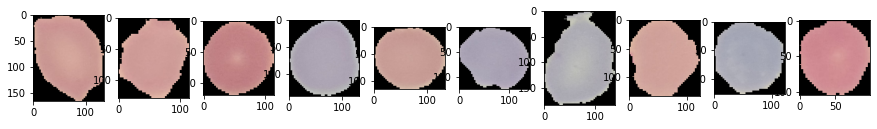

In [9]:
# Visualize some samples (randomly selected) of blood smears from healthy patients 
N_samples = 10
uninfected_dir = os.path.join(cell_images_dir,'Uninfected')
uninfected_samples = random.sample(os.listdir(uninfected_dir), N_samples)
pyplot.figure(figsize=(15,3))
print("{} Uninfected images: view of {} samples".format(len(os.listdir(uninfected_dir)), N_samples))
i = 0
while i < N_samples: # in random.sample(os.listdir(parasitized_dir), 6):
    pyplot.subplot(1,N_samples,1+i)
    img_uninfected = imread(os.path.join(uninfected_dir, uninfected_samples[i]))
    pyplot.imshow(img_uninfected)
    i+=1
print(img_uninfected.shape)

13780 Parasitized images: view of 10 samples
(136, 148, 3)


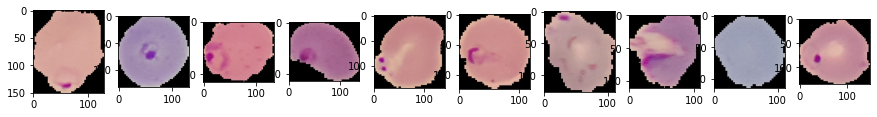

In [10]:
# Visualize some samples (randomly selected) of blood smears from patients falciparum-infected 
print("{} Parasitized images: view of {} samples".format(len(os.listdir(uninfected_dir)), N_samples))
parasitized_dir = os.path.join(cell_images_dir,'Parasitized')
parasitized_samples = random.sample(os.listdir(parasitized_dir), N_samples)
pyplot.figure(figsize=(15,3))
i = 0
while i < N_samples: # in random.sample(os.listdir(parasitized_dir), 6):
    pyplot.subplot(1,N_samples,1+i)
    #Not Implemented
    img_parasitized = imread(os.path.join(parasitized_dir, parasitized_samples[i]))
    pyplot.imshow(img_parasitized)
    i+=1
print(img_parasitized.shape)

### Split train-test

In [11]:
def create_train_test_data(class_name, train_split = 0.8):
    '''
      #Create a function create_train_test_data to split data into 
      #training and testing sets with respectives proportion 80%, 20%
      #--Train (@training_path)
          #--Parasitized
          #--Uninfected
      #--Test (@training_path)
          #--Parasitized
          #--Uninfected
      @class_name: 'Parasitized' or 'Uninfected'
      @train_split: eg. 80% train 20% test
    '''    
    train_class_path = os.path.join(training_path,class_name)  
    test_class_path = os.path.join(testing_path,class_name)

    class_img_names = [img for img in os.listdir(os.path.join(cell_images_dir, class_name))]
    random.seed(42)
    random.shuffle(class_img_names)

    # compute the training and testing split
    i = int(len(class_img_names) * train_split)
    train_class_img_names = class_img_names[:i]
    test_class_img_names = class_img_names[i:]

    def copy_imgs(learn_class_img_names, learn_class_path):
        if not os.path.exists(learn_class_path):
            os.makedirs(learn_class_path)
        for img in learn_class_img_names:
            p_orig = os.path.join(cell_images_dir,class_name,img) 
            p_dest = os.path.join(learn_class_path,img) 
            shutil.copy2(p_orig, p_dest)

    copy_imgs(train_class_img_names, train_class_path)
    copy_imgs(test_class_img_names, test_class_path)

SplitTrainTest = True
if SplitTrainTest == True:
    #Not Implemented
    if os.path.exists(training_path): shutil.rmtree(training_path)
    if os.path.exists(testing_path): shutil.rmtree(testing_path)

    # Create the training and testing subset for Parasitized class
    create_train_test_data('Parasitized', train_split=0.8)
    
    # Create the training and testing subset for Uninfected class
    create_train_test_data('Uninfected', train_split=0.8)
    
# Check if training_path and testing_path folders with both classes are created
!ls train/ test/
# Check the number of files in the Parasitized training set
!ls train/Parasitized | wc -l


test/:
Parasitized  Uninfected

train/:
Parasitized  Uninfected
11024


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


In [12]:
#single convolutional layer with 32 filters followed by a max pooling layer.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BatchSize = 32
xy_shape = 64
n_epochs = 20

In [13]:
# define cnn model
def simple_cnn_model():
    model = Sequential()
    # 1 ConvLayer
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(xy_shape, xy_shape, 3)))
    model.add(MaxPooling2D((2, 2)))
    # Flatten and Dense layers
    model.add(Flatten())
    # Add a Dense (Fully Connected) layer with 128 neurons with 'relu' activation with a kernel_initializer='he_uniform'
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    # Add a Dense output layer with 1 neuron and activated by 'sigmoid'
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
# Instanciate a data generator to fit the model
dataGen = ImageDataGenerator(rescale=1.0/255.0)
# prepare iterators
train_gen = dataGen.flow_from_directory(training_path,class_mode="binary",target_size=(xy_shape, xy_shape),
                                         batch_size=BatchSize)
test_gen = dataGen.flow_from_directory(testing_path,class_mode="binary",target_size=(xy_shape, xy_shape),
                                        batch_size=BatchSize)

Found 22047 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.


In [ ]:
# Instanciate and train the model
conv_net1 = simple_cnn_model()
conv_net1_loss_acc_records = conv_net1.fit_generator(train_gen, steps_per_epoch=len(train_gen),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True)#, workers=) #validation_freq=[1,2,5,10,15,20],

<ipython-input-19-47f3cb63405b>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  conv_net1_loss_acc_records = conv_net1.fit_generator(train_gen, steps_per_epoch=len(train_gen),validation_data=test_gen, validation_steps=len(test_gen),


Epoch 1/20
689/689 [==============================] - 58s 70ms/step - loss: 0.6535 - accuracy: 0.6845 - val_loss: 0.4933 - val_accuracy: 0.7784
Epoch 2/20
689/689 [==============================] - 45s 65ms/step - loss: 0.4021 - accuracy: 0.8300 - val_loss: 0.3491 - val_accuracy: 0.8608
Epoch 3/20
689/689 [==============================] - 45s 65ms/step - loss: 0.2654 - accuracy: 0.8980 - val_loss: 0.2825 - val_accuracy: 0.8880
Epoch 4/20
689/689 [==============================] - 48s 69ms/step - loss: 0.1950 - accuracy: 0.9264 - val_loss: 0.2638 - val_accuracy: 0.8911
Epoch 5/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1503 - accuracy: 0.9461 - val_loss: 0.2922 - val_accuracy: 0.8937
Epoch 6/20
689/689 [==============================] - 45s 65ms/step - loss: 0.1145 - accuracy: 0.9611 - val_loss: 0.3058 - val_accuracy: 0.8973
Epoch 7/20
689/689 [==============================] - 47s 68ms/step - loss: 0.0924 - accuracy: 0.9693 - val_loss: 0.3239 - val_accuracy:

In [15]:
# This function is defined to visualise loss and accuracy
def assess_performance(history):
    pyplot.figure(figsize=(15,3))
    # plot loss
    pyplot.subplot(121)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(122)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

#assess_performance(conv_net1_loss_acc_records)

In [ ]:
# evaluate model
_, acc = conv_net1.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

<ipython-input-21-0577d5d1798f>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = conv_net1.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)


> 88.623


### Data Augmentation

In [18]:
# Use data augmentation techniques to generate more variational data and improve the performance
# data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.
# Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.
# the training dataset will be augmented with small (10%) random horizontal and vertical shifts and random horizontal flips that create a mirror image of a photo. Photos in both the train and test steps will have their pixel values scaled in the same way.

trainAug = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")
# Keep
# dataGen = ImageDataGenerator(rescale=1.0/255.0)


# Generate the new training data using augmentation and testing data 
train_aug = trainAug.flow_from_directory(training_path,class_mode="binary",target_size=(xy_shape, xy_shape),
                                         batch_size=BatchSize)
test_gen = dataGen.flow_from_directory(testing_path,class_mode="binary",target_size=(xy_shape, xy_shape),
                                        batch_size=BatchSize)

Found 22047 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.


In [ ]:
# Train the model with augmented data and assess the performance
conv_net1_aug = simple_cnn_model()
conv_net1_aug_loss_acc_records = conv_net1_aug.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True, workers=2) #validation_freq=[1,2,5,10,15,20],

Epoch 1/20


<ipython-input-23-6ad9c919bfb4>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  conv_net1_aug_loss_acc_records = conv_net1_aug.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen),


689/689 [==============================] - 62s 87ms/step - loss: 0.7233 - accuracy: 0.6718 - val_loss: 0.5761 - val_accuracy: 0.7102
Epoch 2/20
689/689 [==============================] - 61s 89ms/step - loss: 0.4991 - accuracy: 0.7628 - val_loss: 0.6276 - val_accuracy: 0.6977
Epoch 3/20
689/689 [==============================] - 64s 92ms/step - loss: 0.3710 - accuracy: 0.8389 - val_loss: 0.4108 - val_accuracy: 0.8267
Epoch 4/20
689/689 [==============================] - 60s 87ms/step - loss: 0.2915 - accuracy: 0.8837 - val_loss: 0.3819 - val_accuracy: 0.8674
Epoch 5/20
689/689 [==============================] - 60s 86ms/step - loss: 0.2551 - accuracy: 0.9017 - val_loss: 0.2754 - val_accuracy: 0.8991
Epoch 6/20
689/689 [==============================] - 62s 89ms/step - loss: 0.2273 - accuracy: 0.9134 - val_loss: 0.2926 - val_accuracy: 0.8973
Epoch 7/20
689/689 [==============================] - 64s 93ms/step - loss: 0.2089 - accuracy: 0.9237 - val_loss: 0.4170 - val_accuracy: 0.8877
Epo

In [16]:
# Plot loss and accurate and conclude
assess_performance(conv_net1_aug_loss_acc_records)

NameError: ignored

In [ ]:
# evaluate model
_, acc = conv_net1_aug.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

<ipython-input-25-c7faa93d7086>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = conv_net1_aug.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)


> 94.992


## 2-ConvLayers CNN

In [13]:
def cnn_model():
    '''
      Create the 2 layers ConvNet: FirstConvLayer > FirstConvLayer > Flatten > Dense > Dense(output)
    '''
    num_classes = int(input("Enter the mumber of neuron to be activated by sigmoid function :"))
    # Not Implemmented
    model = Sequential()
    # First ConvLayer: use-ing 32 3x3-filters, 'relu' activation function, kernel_initializer='he_uniform', padding='same' with the correct input shape
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(xy_shape, xy_shape, 3)))#Conv2D with above listed parameters
    model.add(MaxPooling2D(pool_size=(2, 2)))  #MaxPooling2D with shape 2x2
    # Second ConvLayer: use-ing 32 3x3-filters, 'relu' activation function
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu')) #Conv2D with above listed parameters
    model.add(MaxPooling2D(pool_size=(2, 2)))  #MaxPooling2D with shape 2x2
    # Flatten followed by Dense and sigmoid Ouput Layers
    model.add(Flatten())  # Flatten
    model.add(Dense(128, activation="relu")) # Dense with 128 neurones, activation='relu', kernel_initializer='he_uniform'
    model.add(Dense(num_classes, activation='sigmoid'))  # Dense with 1 neuron activate by 'sigmoid' function
    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
conv_net2_aug = cnn_model()
conv_net2_aug_loss_acc_records = conv_net2_aug.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True, workers=2) #validation_freq=[1,2,5,10,15,20],

Enter the mumber of neuron to be activated by sigmoid function :1


<ipython-input-14-a3368a5272f2>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  conv_net2_aug_loss_acc_records = conv_net2_aug.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen),


Epoch 1/20
689/689 [==============================] - 69s 82ms/step - loss: 0.4460 - accuracy: 0.7899 - val_loss: 0.2237 - val_accuracy: 0.9156
Epoch 2/20
689/689 [==============================] - 57s 83ms/step - loss: 0.2142 - accuracy: 0.9254 - val_loss: 0.1926 - val_accuracy: 0.9321
Epoch 3/20
689/689 [==============================] - 57s 83ms/step - loss: 0.1945 - accuracy: 0.9349 - val_loss: 0.1678 - val_accuracy: 0.9441
Epoch 4/20
689/689 [==============================] - 58s 84ms/step - loss: 0.1748 - accuracy: 0.9440 - val_loss: 0.1535 - val_accuracy: 0.9490
Epoch 5/20
689/689 [==============================] - 57s 83ms/step - loss: 0.1611 - accuracy: 0.9484 - val_loss: 0.1566 - val_accuracy: 0.9477
Epoch 6/20
689/689 [==============================] - 57s 82ms/step - loss: 0.1566 - accuracy: 0.9494 - val_loss: 0.1871 - val_accuracy: 0.9443
Epoch 7/20
689/689 [==============================] - 58s 84ms/step - loss: 0.1532 - accuracy: 0.9504 - val_loss: 0.1447 - val_accuracy:

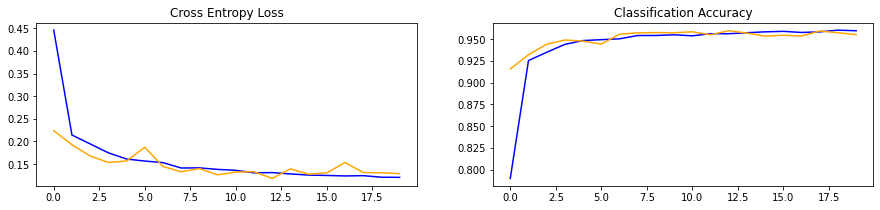

In [20]:
assess_performance(conv_net2_aug_loss_acc_records)

In [21]:
# evaluate model
_, acc = conv_net2_aug.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

<ipython-input-21-24fe779a1018>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = conv_net2_aug.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)


> 95.518


In [16]:
def cnn_model1():
    '''
      Create the 2 layers ConvNet: FirstConvLayer > FirstConvLayer > Flatten > Dense > Dense(output)
    '''
    num_classes = int(input("Enter the mumber of neuron to be activated by sigmoid function :"))
    # Not Implemmented
    model = Sequential()
    # First ConvLayer: use-ing 32 3x3-filters, 'relu' activation function, kernel_initializer='he_uniform', padding='same' with the correct input shape
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(xy_shape, xy_shape, 3)))#Conv2D with above listed parameters
    model.add(MaxPooling2D(pool_size=(2, 2)))  #MaxPooling2D with shape 2x2
    # Second ConvLayer: use-ing 32 3x3-filters, 'relu' activation function
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) #Conv2D with above listed parameters
    model.add(MaxPooling2D(pool_size=(2, 2)))  #MaxPooling2D with shape 2x2
    # Flatten followed by Dense and sigmoid Ouput Layers
    model.add(Flatten())  # Flatten
    model.add(Dense(128, activation="relu")) # Dense with 128 neurones, activation='relu', kernel_initializer='he_uniform'
    model.add(Dense(num_classes, activation='sigmoid'))  # Dense with 1 neuron activate by 'sigmoid' function
    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [19]:
conv_net2_aug = cnn_model1()
conv_net2_aug_loss_acc_records = conv_net2_aug.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen), 
                              epochs=n_epochs, verbose=1, use_multiprocessing=True, workers=2) #validation_freq=[1,2,5,10,15,20],

<ipython-input-19-6392b0cd670d>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  conv_net2_aug_loss_acc_records = conv_net2_aug.fit_generator(train_aug, steps_per_epoch=len(train_aug),validation_data=test_gen, validation_steps=len(test_gen),


Epoch 1/20
689/689 [==============================] - 67s 81ms/step - loss: 0.6140 - accuracy: 0.6656 - val_loss: 0.3974 - val_accuracy: 0.8405
Epoch 2/20
689/689 [==============================] - 56s 81ms/step - loss: 0.2859 - accuracy: 0.8911 - val_loss: 0.2047 - val_accuracy: 0.9247
Epoch 3/20
689/689 [==============================] - 58s 84ms/step - loss: 0.1967 - accuracy: 0.9296 - val_loss: 0.1588 - val_accuracy: 0.9447
Epoch 4/20
689/689 [==============================] - 56s 81ms/step - loss: 0.1718 - accuracy: 0.9408 - val_loss: 0.1533 - val_accuracy: 0.9479
Epoch 5/20
689/689 [==============================] - 56s 81ms/step - loss: 0.1563 - accuracy: 0.9481 - val_loss: 0.1469 - val_accuracy: 0.9519
Epoch 6/20
689/689 [==============================] - 56s 80ms/step - loss: 0.1526 - accuracy: 0.9500 - val_loss: 0.1334 - val_accuracy: 0.9570
Epoch 7/20
689/689 [==============================] - 55s 80ms/step - loss: 0.1452 - accuracy: 0.9516 - val_loss: 0.1470 - val_accuracy:

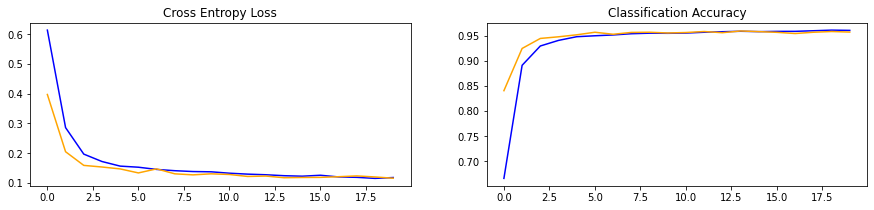

In [20]:
assess_performance(conv_net2_aug_loss_acc_records)

In [21]:
# evaluate model
_, acc = conv_net2_aug.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)
print('> %.3f' % (acc * 100.0))

<ipython-input-21-24fe779a1018>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = conv_net2_aug.evaluate_generator(test_gen, steps=len(test_gen), use_multiprocessing=True, verbose=0)


> 95.736


## Compare performance results

*   conv_net1: 
*   conv_net1_aug
*   conv_net2_aug:
*   conv_deep_transfer:

***Conclusion:***

## Assignment: Work to improve the performance - try different strategies:
* Hyperparameters tuning
* Test other models
  - eg. ResNet, VGG